# OpenStreetMap Data Wrangling with MongoDB

## Project Overview
In this project , i will select map data for an area from OpenStreetMap and use data wrangling techniquesto assess the  validity, accuracy, completeness, consistency and uniformity of the data. I will clean the dataset, upload it to mongodb and make my own analysis to find some interesting insights.

## 1. Download the data.
The area I choose to look at is Kenmore,Washington, which is the city i live in. I downloaded the dataset from OpenStreetMap via Overpass API. I will apply the techniques learned from Udacity's Data Wrangling with MongoDB course to explore, audit and clean this dataset then convert the xml to JSON.

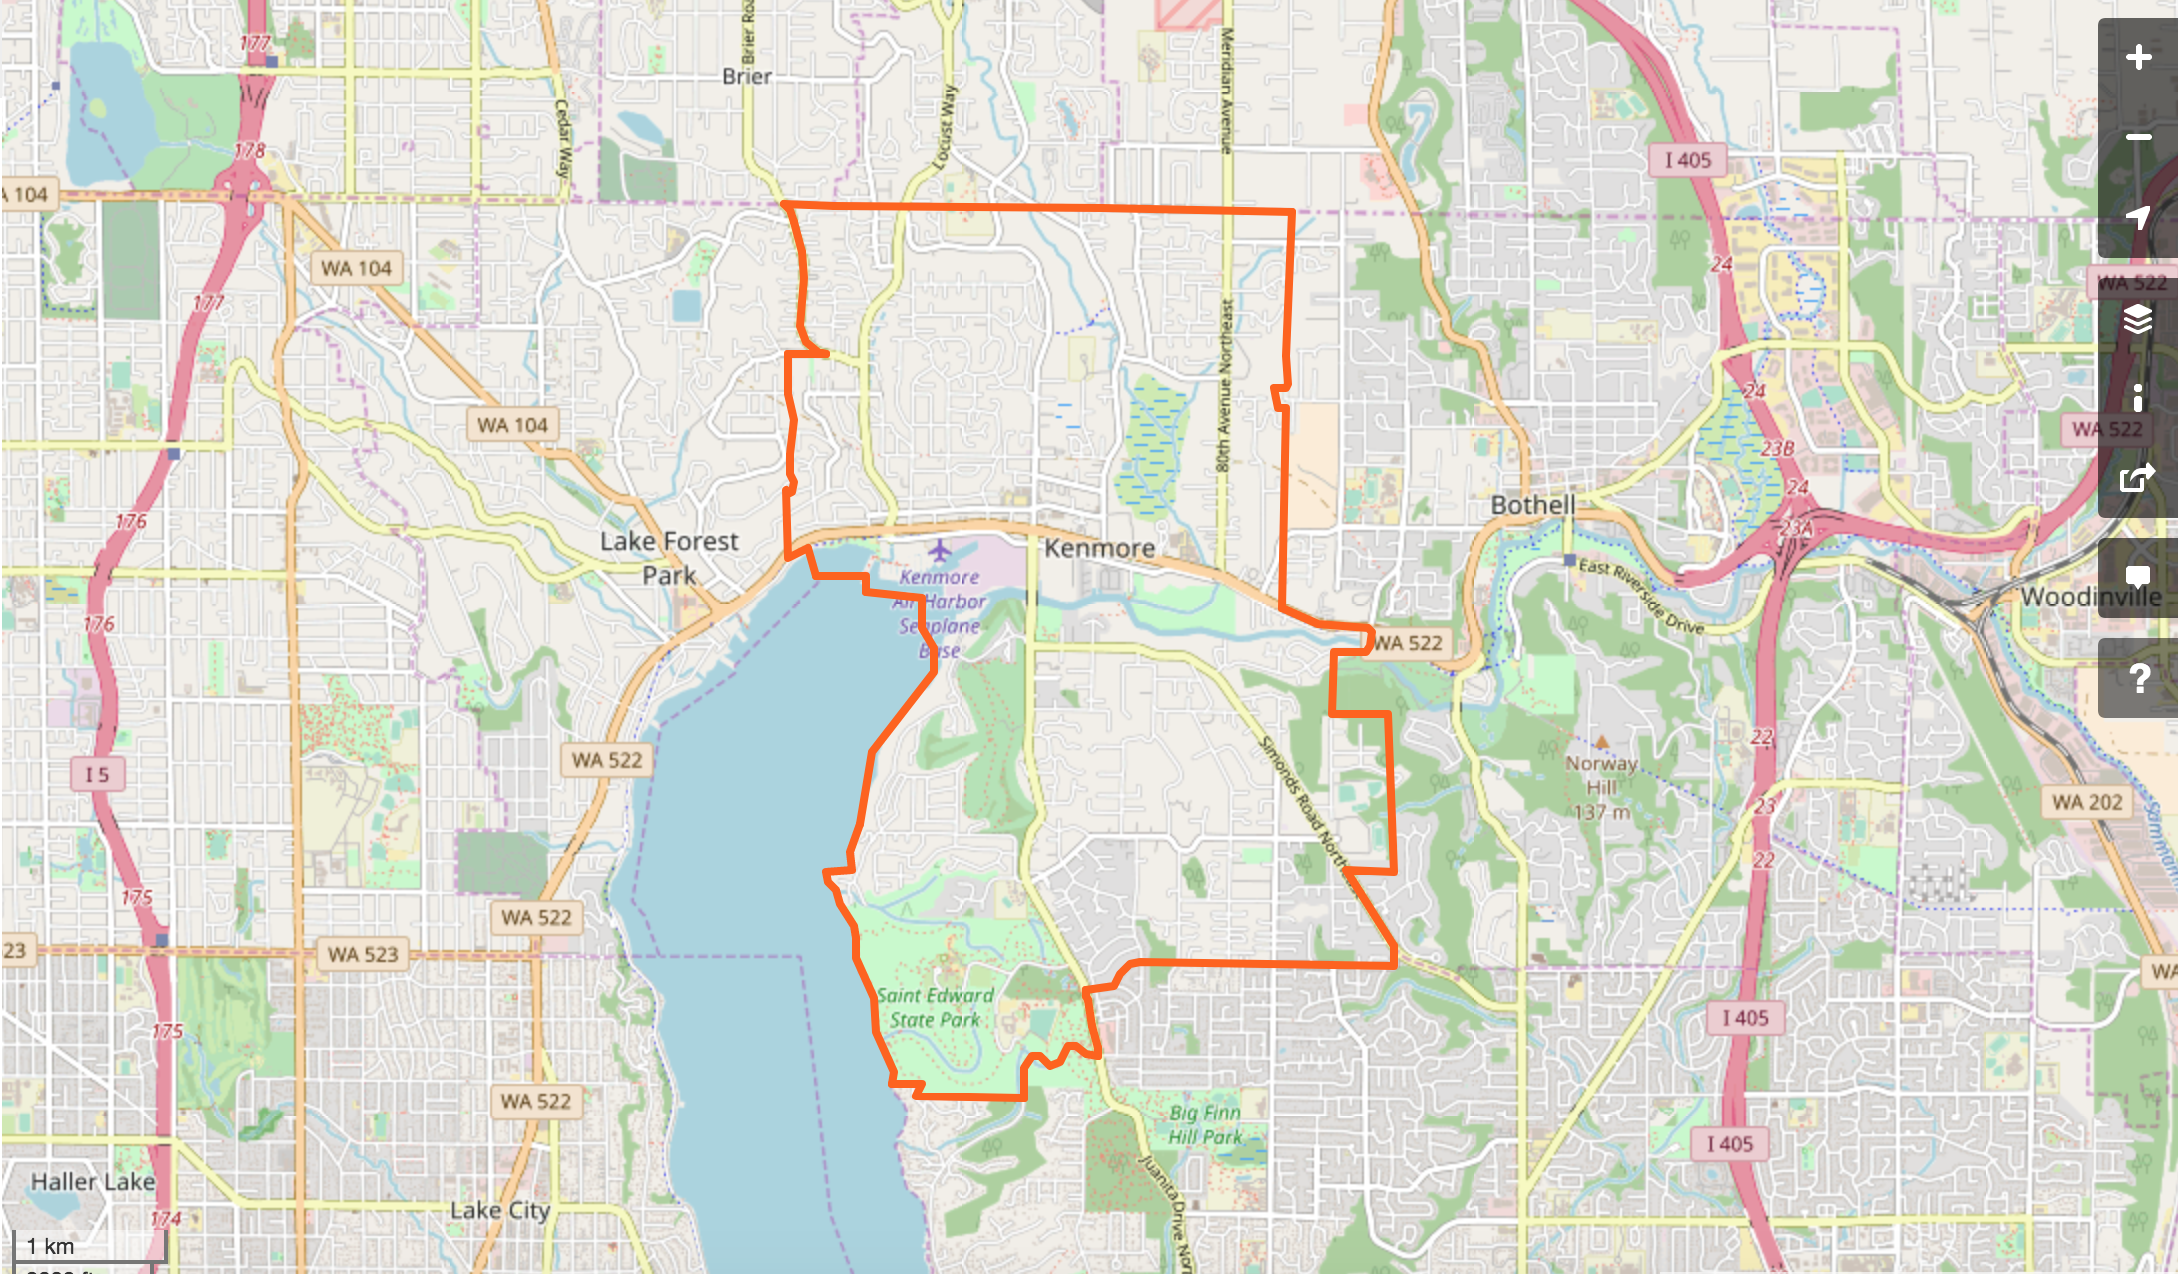

In [47]:
from IPython.display import Image
Image("kenmore.png", width ="600")

In [21]:
import requests

data_url = 'http://overpass-api.de/api/map?bbox=-122.3383,47.7138,-122.1515,47.7867'
filename = 'kenmore.osm'

def download_file(url, file_name):
    r = requests.get(url, stream = True)
    with open(file_name, 'wb') as f:
        print "Downloading %s" % file_name, '...'
        data_size = 0
        for chunk in r.iter_content(chunk_size=1026): 
            if chunk:
                f.write(chunk)
                data_size += len(chunk)
                f.flush()
        print "Finish downloading, the data size is " + str(data_size) + "!"

In [22]:
download_file(data_url, filename)

Finish downloading, the data size is 71416379!


## 2. Audit the data.
Before adding it to Mongodb, we need to check if there're any data quality issues in there.
I will parse through it with ElementTree and start with counting different elements.

In [23]:
import xml.etree.ElementTree as ET
import pprint

def count_tag(filename):
    tags = {}
    for event, elem in ET.iterparse(filename):
        if elem.tag in tags:
            tags[elem.tag] += 1
        else:
            tags[elem.tag] = 1

    pprint.pprint(tags)  

In [24]:
count_tag(filename)

{'bounds': 1,
 'member': 8145,
 'meta': 1,
 'nd': 341142,
 'node': 303563,
 'note': 1,
 'osm': 1,
 'relation': 325,
 'tag': 194947,
 'way': 33921}


Because what i'm most interested in is the tag keys. I then looped through all tag keys and printed them.

In [25]:
def audit_tag_keys(filename):
        keys_dict = {}
        for event, elem in ET.iterparse(filename):
            for attr in elem.iter("tag"):
                key = attr.attrib["k"]

                if key not in keys_dict:
                    keys_dict[key] = 1
                else:
                    keys_dict[key] += 1

        return keys_dict

In [91]:
tag_key = audit_tag_keys(filename)

sorted(tag_key.items(), key=lambda x: (-x[1], x[0]))

[('addr:housenumber', 69105),
 ('addr:street', 69060),
 ('addr:postcode', 68970),
 ('addr:city', 68868),
 ('building', 68445),
 ('source', 40278),
 ('highway', 32385),
 ('name', 19917),
 ('addr:unit', 12804),
 ('tiger:county', 12669),
 ('tiger:cfcc', 12597),
 ('tiger:name_base', 12009),
 ('tiger:reviewed', 8835),
 ('tiger:name_direction_suffix', 6696),
 ('service', 5166),
 ('tiger:name_direction_prefix', 4854),
 ('power', 4614),
 ('lanes', 4398),
 ('maxspeed', 3792),
 ('tiger:name_type', 3405),
 ('amenity', 2925),
 ('ref', 2664),
 ('oneway', 2577),
 ('created_by', 2334),
 ('bicycle', 2121),
 ('natural', 1701),
 ('landuse', 1542),
 ('surface', 1290),
 ('public_transport', 1257),
 ('tiger:name_base_1', 1233),
 ('gtfs:stop_id', 1227),
 ('lanes:backward', 1182),
 ('lanes:forward', 1182),
 ('cycleway', 1008),
 ('leisure', 990),
 ('type', 984),
 ('source:addr:id', 849),
 ('shop', 831),
 ('waterway', 771),
 ('gtfs:dataset_id', 759),
 ('foot', 672),
 ('layer', 621),
 ('website', 618),
 ('old_r

Finally, i also audited if there're any problematic tag keys that are not available Mongodb, i printed number of keys for each type and found no problematic keys.

In [27]:
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        
        if problemchars.search(element.attrib['k']):
            keys['problemchars'] += 1
        elif lower.search(element.attrib['k']):
            keys['lower'] += 1
        elif lower_colon.search(element.attrib['k']):
            keys['lower_colon'] += 1 
        else:
            keys['other'] += 1
        
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

In [28]:
keys = process_map(filename)
pprint.pprint(keys)

{'lower': 72762, 'lower_colon': 120222, 'other': 1963, 'problemchars': 0}


## 3. Problems in the dataset


### 3.1 Street Name
I found first of all the inconsistencies in the street names, with some use abbreviations while some not. I then updated the abbreviations with the full names.
Here're two examples, for those whose ending with numbers, i put them to the front:
    15th Ave Northeast  =>  15th Avenue
    Lake City Way Northeast #183  =>  No.183 Lake City Way Northeast
The following is the process:
    1. create the regex format of finding abbreviations, also create the expected full name and the mapping of abbreviation to its full name.
    2. Audit each value within <tag> with key equals "addr:street", if the pattern is not expected, update using the mapping dictionary.
    3. Save the file with the updated street name.

In [37]:
import re
from collections import defaultdict


street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons"]


mapping = { "pl": "Place",
            "st": "Street",
            "ave": "Avenue",
            "rd": "Road",
            "w": "West",
            "n": "North",
            "s": "South",
            "e": "East",
            "blvd":"Boulevard",
            "sr": "Drive",
            "ct": "Court",
            "ne": "Northeast",
            "se": "Southeast",
            "nw": "Northwest",
            "sw": "Southwest",
            "dr": "Drive",
            "sq": "Square",
            "ln": "Lane",
            "trl": "Trail",
            "pkwy": "Parkway",
            "ste": "Suite",
            "lp": "Loop",
            "hwy": "Highway"}

In [79]:
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)
            
            
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(filename):
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    return street_types


def update_name(name, mapping):
    name_list = re.findall(r"[\w#]+", name)
    end_of_street_name = len(name_list)
    
    
    for i in range(len(name_list)):
        word = name_list[i].lower()
        if word in mapping:
            name_list[i] = mapping[word]
        if "#" in word:
            name_list[i] = name_list[i].replace("#","No ")
            name_list = [name_list[i]] + name_list[0:i]
        
    name_list = name_list[:(end_of_street_name+1)]
    better_name = ' '.join(name_list)
    return better_name

In [80]:
street_types = audit(filename)

for str_type, namel in street_types.iteritems():
    for name in namel:
        better_name = update_name(name, mapping)
        if name != better_name:
            print name, " => ", better_name

124th Avenue Northeast  #A  =>  No A 124th Avenue Northeast
15TH Ave Northeast  =>  15TH Avenue Northeast
Juanita-Woodinville Way Northeast  =>  Juanita Woodinville Way Northeast
Pinehurst Pocket Park;19th Avenue Northeast  =>  Pinehurst Pocket Park 19th Avenue Northeast
15th Ave Northeast  =>  15th Avenue Northeast
Lake City Way Northeast #183  =>  No 183 Lake City Way Northeast
233rd St SW  =>  233rd Street Southwest
25th Ave NE  =>  25th Avenue Northeast
138th Way NE  =>  138th Way Northeast
18006 120TH AVE NE  =>  18006 120TH Avenue Northeast
104th Ave NE  =>  104th Avenue Northeast
141st Pl NE  =>  141st Place Northeast
Ballinger Way NE  =>  Ballinger Way Northeast
Bothell Way NE  =>  Bothell Way Northeast
120th Avenue NE  =>  120th Avenue Northeast
NE 158th St  =>  Northeast 158th Street
NE 186th St  =>  Northeast 186th Street
Main St  =>  Main Street
NE Bothell Way  =>  Northeast Bothell Way
Bothell-Everett Highway  =>  Bothell Everett Highway


These are the names finally been updated.

In [81]:
def clean_street_name(filename, cleaned_filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    
    for tag in root.findall('*/tag'):
        if is_street_name(tag):
            name = tag.get('v')
            better_name = update_name(name, mapping)
            tag.set('v', better_name)

    return tree.write(cleaned_filename)



cleaned_street_name = 'kenmore_updated_street.xml'
clean_street_name(filename, cleaned_street_name)

Finally update all incorrect street names and  save the new file as 'kenmore_updated_street.xml'

In [82]:
street_types = audit(cleaned_street_name)

for st_type, ways in street_types.iteritems():
    for name in ways:
        better_name = update_name(name, mapping)
        if name != better_name:
            print name, "=>", better_name

By checking again, we found there're no street names needed to be updated. Auditing done.

## 3.2 City Name
I also found inconsistencies in the city names. Some city name's are miss spelled and some are not capitalized. Then i updated the city names to fix the wrong spelling issue.
The following is the process:
    1. create a correct list of city names in the map area.
    2. Audit each "addr:city" value and list all city names in the file.
    3. Because there're only 13 different city names in total, easy to find the incorrect spellings and non-capitalization names. Update them to the correct name and format.
    4. Save the new file with city name updated.

In [88]:
city_name_list = ['Bothell','Edmonds','Kenmore','Kirkland','Lake Forest Park','Mountlake Terrace'
                         ,'Seattle','Shoreline','Woodinville']

def is_city_name(elem):
    return (elem.attrib['k'] == "addr:city")


def audit_city(filename):
    city_types = set()
    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_city_name(tag):
                    city_types.add(tag.get('v'))
    return city_types


def update_city_name(name):
    if name in ['BOTHELL','Bothel']:
        better_name = 'Bothell'
    elif name == 'Woodenville':
        better_name = 'Woodinville'
    elif name == 'kenmore':
        better_name = 'Kenmore'
    else:
        better_name = name
    return better_name

In [84]:
city_type = audit_city(filename)

In [85]:
city_type

{'BOTHELL',
 'Bothel',
 'Bothell',
 'Edmonds',
 'Kenmore',
 'Kirkland',
 'Lake Forest Park',
 'Mountlake Terrace',
 'Seattle',
 'Shoreline',
 'Woodenville',
 'Woodinville',
 'kenmore'}

By pulling all city namesin the file, there're only 13 names, so its easy to audit and make corrections using if-else logic.

In [89]:
def clean_city_name(filename, cleaned_filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    
    for tag in root.findall('*/tag'):
        if is_city_name(tag):
            name = tag.get('v')
            better_name = update_city_name(name)
            tag.set('v', better_name)

    return tree.write(cleaned_filename)



cleaned_city_name = 'kenmore_updated_streetcity.xml'
clean_city_name(cleaned_street_name, cleaned_city_name)

Finally update all incorrect city names and save the new file as 'kenmore_updated_streetcity.xml'

In [90]:
city_type = audit_city(cleaned_city_name)
city_type

{'Bothell',
 'Edmonds',
 'Kenmore',
 'Kirkland',
 'Lake Forest Park',
 'Mountlake Terrace',
 'Seattle',
 'Shoreline',
 'Woodinville'}

By checking again, we found there're no city names needed to be updated. Auditing done.

## 4.Overview of Data

### 4.1 Convert from xml to json format
The following is the process:
    1. Process 2 types of top level tags: node and way.
    2. All attributes of node and way should be turned into key/value pairs.
    3. Problematic tag keys are ignored.
    4. Tag keys starts with "addr:" will be added to a dictionary address.

In [127]:
from datetime import datetime

def shape_element(element):
    node = {}
    CREATED = ["version", "changeset", "timestamp", "user", "uid"]
    
    if element.tag == "node" or element.tag == "way" :
        node['type'] = element.tag

        # Parse attributes
        for a in element.attrib:
        
            # Parse details of data creation
            if a in CREATED:
                if 'created' not in node:
                    node['created'] = {}

                if a == "timestamp":
                    node['created'][a] = str(datetime.strptime(element.attrib[a], '%Y-%m-%dT%H:%M:%SZ').date())
                else:
                    node['created'][a] = element.attrib[a]
        
            # Parse coordinates
            elif a in ['lat', 'lon']:
                if 'pos' not in node:
                    node['pos'] = [None, None]

                if a == 'lat':
                    node['pos'][0] = float(element.attrib[a])
                else:
                    node['pos'][1] = float(element.attrib[a])
        
            else:
                node[a] = element.attrib[a]

        # Iterate tag children
        for tag in element.iter("tag"):
            if not problemchars.search(tag.attrib['k']):

                # Tags with single colon and beginning with addr
                if lower_colon.search(tag.attrib['k']) and tag.attrib['k'].find('addr') == 0:
                    if 'address' not in node:
                        node['address'] = {}

                    sub_attr = tag.attrib['k'].split(':', 1)

                    node['address'][sub_attr[1]] = tag.attrib['v']

                # All other tags that don't begin with "addr"
                elif not tag.attrib['k'].find('addr') == 0:
                    if tag.attrib['k'] not in node:
                        node[tag.attrib['k']] = tag.attrib['v']
                else:
                    node["tag:" + tag.attrib['k']] = tag.attrib['v']
                
        # Iterate nd children building a list
        for nd in element.iter("nd"):
            if 'node_refs' not in node:
                node['node_refs'] = []
            
            node['node_refs'].append(nd.attrib['ref'])

        return node
    else:
        return None

In [128]:
import json
import codecs 

def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

In [129]:
process_map(cleaned_city_name)

[{'created': {'changeset': '1193754',
   'timestamp': '2009-05-14',
   'uid': '8609',
   'user': 'ewedistrict',
   'version': '6'},
  'id': '29937707',
  'pos': [47.6967276, -122.276789],
  'type': 'node'},
 {'created': {'changeset': '640330',
   'timestamp': '2008-10-31',
   'uid': '34124',
   'user': 'Sunny',
   'version': '3'},
  'id': '29937708',
  'pos': [47.6970172, -122.2758057],
  'type': 'node'},
 {'created': {'changeset': '11599644',
   'timestamp': '2012-05-14',
   'uid': '92286',
   'user': 'Paul Johnson',
   'version': '4'},
  'id': '29937709',
  'pos': [47.6972499, -122.275166],
  'type': 'node'},
 {'created': {'changeset': '11599644',
   'timestamp': '2012-05-14',
   'uid': '92286',
   'user': 'Paul Johnson',
   'version': '4'},
  'id': '29937710',
  'pos': [47.6974448, -122.2747392],
  'type': 'node'},
 {'created': {'changeset': '11599644',
   'timestamp': '2012-05-14',
   'uid': '92286',
   'user': 'Paul Johnson',
   'version': '5'},
  'id': '29937711',
  'pos': [47.69

### 4.2 Upload the json file to Mongodb

I used pymongo to create the requested database and used subprocess package to run shell commands to import json files. 

#### Size of two files 

In [133]:
from subprocess import check_output, Popen, PIPE

osm = re.sub(r'[\s]', ' ', check_output("du -h kenmore_updated_streetcity.xml".split()))
json = re.sub(r'[\s]', ' ', check_output("du -h kenmore_updated_streetcity.xml.json".split())); print(osm + '\n' + json)

 69M kenmore_updated_streetcity.xml 
 72M kenmore_updated_streetcity.xml.json 


In [2]:
import signal
import subprocess
import os


pro = subprocess.Popen("mongod", preexec_fn = os.setsid) 

In [3]:
from pymongo import MongoClient
import bson

db_name = "udacity_proj"

client = MongoClient()
db = client[db_name]

In [5]:
collection = "osm_kenmore"
json_file = cleaned_city_name + ".json"

mongoimport_cmd = "mongoimport --db " + db_name + \
                  " --collection " + collection + \
                  " --file " + json_file

# drop collection if it exists
if collection in db.collection_names():
    print "dropping collection"
    db[collection].drop()

# Execute the command
print "Executing: " + mongoimport_cmd
subprocess.call(mongoimport_cmd.split())

Executing: mongoimport --db udacity_proj --collection osm_kenmore --file kenmore_updated_streetcity.xml.json


0

In [6]:
data_db = db[collection]

### 4.3 Some statistics about the dataset

#### Number of Documents

In [7]:
data_db.find().count()

337484

#### Number of Nodes

In [8]:
data_db.find({"type":"node"}).count()

303563

#### Number of Ways

In [9]:
data_db.find({"type":"way"}).count()

33921

#### Number of unique users 

In [11]:
len(data_db.distinct("created.user"))

337

#### Top 10 contributor

In [24]:
for doc in data_db.aggregate([
                            {"$match": {'created.user': {"$exists": 1} }},
                             {"$group": {"_id": '$created.user', "count": {"$sum": 1}}},
                             {"$sort": {'count': -1}},
                             {"$limit": 10}
                            ]):
    print doc

{u'count': 74061, u'_id': u'Glassman_Import'}
{u'count': 72466, u'_id': u'SeattleImport'}
{u'count': 67797, u'_id': u'seattlefyi_import'}
{u'count': 20312, u'_id': u'Glassman'}
{u'count': 13008, u'_id': u'bdp'}
{u'count': 12764, u'_id': u'STBrenden'}
{u'count': 9851, u'_id': u'Natfoot'}
{u'count': 7220, u'_id': u'sctrojan79-import'}
{u'count': 6785, u'_id': u'Debbie Bull'}
{u'count': 6014, u'_id': u'compdude'}


#### Top amenity

In [42]:
for doc in data_db.aggregate([
                            {"$match": {'amenity': {"$exists": 1} }},
                             {"$group": {"_id": '$amenity', "count": {"$sum": 1}}},
                             {"$sort": {'count': -1}},
                             {"$limit": 10}
                            ]):
    print doc

{u'count': 313, u'_id': u'parking'}
{u'count': 71, u'_id': u'restaurant'}
{u'count': 67, u'_id': u'school'}
{u'count': 52, u'_id': u'fast_food'}
{u'count': 49, u'_id': u'place_of_worship'}
{u'count': 49, u'_id': u'bench'}
{u'count': 35, u'_id': u'cafe'}
{u'count': 34, u'_id': u'fuel'}
{u'count': 32, u'_id': u'bicycle_parking'}
{u'count': 25, u'_id': u'bank'}


#### Top street

In [30]:
for doc in data_db.aggregate([
                            {"$match": {'address.street': {"$exists": 1} }},
                             {"$group": {"_id": '$address.street', "count": {"$sum": 1}}},
                             {"$sort": {'count': -1}},
                             {"$limit": 1}
                            ]):
    print doc

{u'count': 524, u'_id': u'Northeast 132nd Street'}


### 4.4 Other thoughts on the dataset
Besides the statistics above, i'm also interested in verifying the most popular fast food restaurant in this area. In my memory, Subway should have most stores. I also want see if Starbuck and BOA both have more stores than their competitors in this area, just like bellevue downtown.

Through some aggregations, i found:
    1. Subway has 8 stores, higher than all other competitors.
    2. Startbuck is dominant in Kenmore area.
    3. BOA has 6 store in this area, which is the same as its biggest competitor Chase.
These findings demonstared my assumption, which is interesting.

In [45]:
for doc in data_db.aggregate([
                            {"$match": {'amenity': 'fast_food' }},
                             {"$group": {"_id": '$name', "count": {"$sum": 1}}},
                             {"$sort": {'count': -1}},
                             {"$limit": 5}
                            ]):
    print doc

{u'count': 8, u'_id': u'Subway'}
{u'count': 6, u'_id': u"McDonald's"}
{u'count': 3, u'_id': u'Taco Time'}
{u'count': 3, u'_id': u'Jack in the Box'}
{u'count': 2, u'_id': u"Domino's Pizza"}


In [38]:
for doc in data_db.aggregate([
                            {"$match": {'amenity': 'cafe' }},
                             {"$group": {"_id": '$name', "count": {"$sum": 1}}},
                             {"$sort": {'count': -1}},
                             {"$limit": 5}
                            ]):
    print doc

{u'count': 9, u'_id': u'Starbucks'}
{u'count': 2, u'_id': u'Brew'}
{u'count': 1, u'_id': u'Perfetto Espresso'}
{u'count': 1, u'_id': u'Cold Stone Creamery'}
{u'count': 1, u'_id': u'192 Brewing Co. espresso stand'}


In [37]:
for doc in data_db.aggregate([
                            {"$match": {'amenity': 'bank' }},
                             {"$group": {"_id": '$name', "count": {"$sum": 1}}},
                             {"$sort": {'count': -1}},
                             {"$limit": 5}
                            ]):
    print doc

{u'count': 6, u'_id': u'Bank of America'}
{u'count': 6, u'_id': u'Chase'}
{u'count': 3, u'_id': u'Wells Fargo'}
{u'count': 3, u'_id': u'Washington Federal'}
{u'count': 2, u'_id': u'US Bank'}


## Conclusion
The map data of Kenmore area has a good data quality in general. However, there're some inconsistencies in street names where some have abbreviations and there're incorrect spellings in city names. All these issues are found by auditing and finnaly fixed by replacing with the correct formats.The project tells me the importance of data quality and teaches me how to QA the data efficiently.